In [1]:
from sklearn import datasets
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
import scipy
import numpy as np
from gap_statistic import OptimalK

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

(6000, 2)

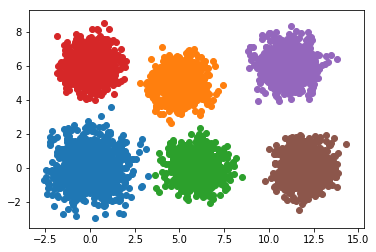

In [24]:
blob1 = np.random.multivariate_normal([0,0], [[1,0],[0,1]], 1000)
blob2 = np.random.multivariate_normal([5,5], [[0.5,0],[0,0.5]], 1000)
blob3 = np.random.multivariate_normal([6,0], [[0.5,0],[0,0.5]], 1000)
blob4 = np.random.multivariate_normal([0,6], [[0.5,0],[0,0.5]], 1000)
blob5 = np.random.multivariate_normal([11,6], [[0.5,0],[0,0.5]], 1000)
blob6 = np.random.multivariate_normal([12,0], [[0.5,0],[0,0.5]], 1000)
plt.scatter(blob1[:,0], blob1[:,1])
plt.scatter(blob2[:,0], blob2[:,1])
plt.scatter(blob3[:,0], blob3[:,1])
plt.scatter(blob4[:,0], blob4[:,1])
plt.scatter(blob5[:,0], blob5[:,1])
plt.scatter(blob6[:,0], blob6[:,1])
# data_X = np.vstack((blob1,blob2))
# data_X = np.vstack((blob1,blob2,blob3))
# data_X = np.vstack((blob1,blob2,blob3,blob4))
# data_X = np.vstack((blob1,blob2,blob3,blob4,blob5))
data_X = np.vstack((blob1,blob2,blob3,blob4,blob5,blob6))
data_X.shape

### Gap Statistics
$n_r = |C_r|$ (cardinalidade do cluster r)

$D_r = \sum_{i,i'\epsilon C_r}{d_{i,i'}}$ (pairwise-distance entre todos os elementos de um cluster)

$W_k = \sum_{r=1}^{k}{\frac{1}{2n_r}D_r}$ (média ponderada da soma das distâncias dentro de cada cluster - pooled within-cluster sum around the cluster means)

A ideia não é escolher a quantidade de clusters que minimiza a distância interna, pois esse sempre diminui conforme aumentamos o número de clusters. A estatística busca encontrar o valor que minimiza essa distância quando comparado a uma distribuição de referência dos dados. (Ou seja, a quantidade de clusters que mais faz diferença pela clusterização e não pelo fato de estamos aumentando o número de clusters)

$Gap_n(k) = E^*\{log(W_k)\} - log(W_k)$ (onde $E^*$ é o valor esperado de uma amostra de tamanho $n$ da distribuição de referência. O valor estimado $\widehat{k}$ é o valor que maximiza o $Gap_n(k)$ depois de levar em consideração a distribuição.

In [25]:
def calculate_wk(X, y, distance='euclidean'):
    """ Calculate nr, dr and wk """
    min_k = np.array(y).min()
    max_k = np.array(y).max()
    wk = []
    
    for i in range(min_k, max_k+1):
        # Calculate Dr for each cluster
        obs_idx = np.where(y == i)[0]
        nr = obs_idx.shape[0]
        
#         if nr == 0:
#             raise TypeError("There are empty clusters.")
        
        # Get pairwise distance
        dist = pdist(X[obs_idx], distance).sum()
        
        # Calculate Wk
        wki = dist/(2*nr)
        wk.append(wki)
    
    return np.array(wk).sum()

def get_clusters(X, k, mode='hierarquical', **kwargs):
    """ Different clustering modes. """
    if mode == 'hierarquical':
        # Create linkage matrix for original data
        Z = hierarchy.linkage(X, **kwargs)
        clusters = hierarchy.fcluster(Z, k, criterion='maxclust')    
    elif mode == 'kmeans':
        clusters = KMeans(n_clusters=k).fit_predict(X)
    return clusters

### Prepare reference dataset

In [26]:
def prepare_ref_dataset(data, nrefs=20):
    shape = data.shape
    # Set bounding box
    tops = data.max(axis=0)
    bots = data.min(axis=0)

    # Generate distribution
    rands = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))

    # Set offset for random uniform samples to be inside bounding boxes
    dists = scipy.matrix(scipy.diag(tops-bots))
    for i in range(nrefs):
        rands[:,:,i] = rands[:,:,i]*dists+bots
        
    return rands

### Cluster

In [27]:
optimalK = OptimalK(parallel_backend='rust')
optimalK

OptimalK(n_jobs=4, parallel_backend="rust")

In [28]:
def calculate_gap(X, refs, k_max, mode='hierarquical'):
    gaps = []
    gaps2 = []
    error = []
    wks = []
    wkbs = []
    
    for k in range(1,k_max+1):
        # Calculate Wk for original data
        clusters = get_clusters(X, k, mode, method='ward')
        wk = calculate_wk(X, clusters)
        wks.append(wk)
        log_wk = np.log(wk)

        # Calculate Wk for reference distribution
        wk_refs = []
        for ref in range(refs.shape[2]):
            clusters = get_clusters(refs[:,:,ref], k, mode, method='ward')
            wk_ref = calculate_wk(refs[:,:,ref], clusters)
            log_wk_ref = np.log(wk_ref)
            wk_refs.append(log_wk_ref)
        wkb = np.array(wk_refs)
        wkb_sum = wkb.sum()
        wkb_std = wkb.std()
        B = wkb.shape[0]

        # Calculate Gap
        wkbs.append(1/B*wkb_sum)
        gap_k = (1/B*wkb_sum) - log_wk
        gaps.append(gap_k)
        error.append(wkb_std*np.sqrt(1+(1/B)))
#         error2.append(wkb_std*np.sqrt(1+(1/B)))
    
    return gaps, error, wks, wkbs, gaps2

def define_k(gaps, error):
    for i in range(1,k_max):
        k = i-1
        gapi = gaps[k]
        gapi1 = gaps[k+1]
        std = error[k+1]
        
        if gapi >= (gapi1-std):
            print("k = %d" % i)
            break
            
    diff = np.array(gaps) - np.array(error)
    gaps[1:] = gaps[:-1]
    gap_diff = np.array(gaps) > diff
    k = np.argmax(gap_diff[1:] == True)
    print("k = %d" % (k+1))
    


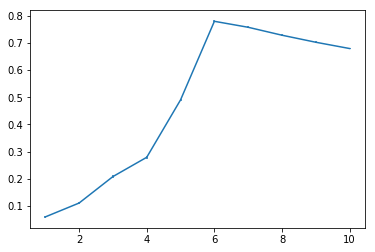

k = 6
k = 6
Optimal K: 9
CPU times: user 7min 16s, sys: 7min 28s, total: 14min 44s
Wall time: 6min 43s


In [29]:
%%time
refs = prepare_ref_dataset(data_X, nrefs=100)
k_max = 10

# Calculate gaps and error
gaps, error, wks, wkbs, gaps2 = calculate_gap(data_X, refs, k_max, 'kmeans')

# Plot data
plt.errorbar(range(1,len(gaps)+1), gaps, yerr=error)
plt.show()

# Get best k
k = define_k(gaps, error)
k2 = optimalK(data_X, cluster_array=np.arange(1, 11))
print("Optimal K: %d" % k2)

In [90]:
optimalK.gap_df

,n_clusters,gap_value
0,1.0,-4.637896
1,2.0,-4.610715
2,3.0,-4.043241
3,4.0,-2.701449
4,5.0,-2.881190
5,6.0,-2.807741
6,7.0,-2.953758
7,8.0,-3.718136
8,9.0,-3.361590
9,10.0,-3.282791


In [101]:
gaps

[-0.0005351355070555286,
 -0.0005351355070555286,
 0.008249984237356678,
 -0.19399035701360656,
 -0.003398691214432148,
 0.40541379978306136,
 0.2229231220653327,
 0.04666713786249588,
 0.014829163328476724,
 -0.0977635099045635]

In [102]:
error

[0.025661121540529935,
 0.25663902962358087,
 0.33784323973853914,
 0.17322539220326344,
 0.35175046000413523,
 0.3450580047822025,
 0.37709004957911507,
 0.3883478312366023,
 0.26480028832925706,
 0.36884281780531647]

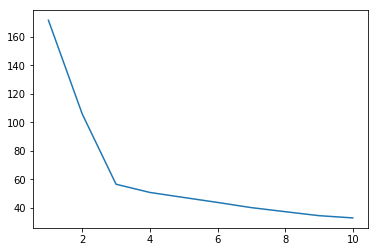

In [61]:
plt.plot(list(range(1,k_max+1)), wks)

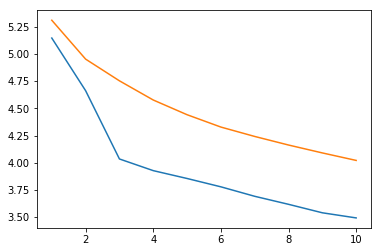

In [62]:
plt.plot(list(range(1,k_max+1)), np.log(wks))
plt.plot(list(range(1,k_max+1)), wkbs)